# Predicting AAPL stock price with an LSTM

In [30]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn

In [11]:
data = pd.read_csv("AAPL.csv")
data.head()

,Date,Close/Last,Volume,Open,High,Low
0,10/22/2024,$235.86,38846580,$233.885,$236.22,$232.60
1,10/21/2024,$236.48,36254470,$234.45,$236.85,$234.45
2,10/18/2024,$235.00,46431470,$236.18,$236.18,$234.01
3,10/17/2024,$232.15,32993810,$233.43,$233.85,$230.52
4,10/16/2024,$231.78,34082240,$231.60,$232.12,$229.84


In [12]:
data["Close/Last"] = [np.float32(val[1:]) for val in data["Close/Last"]]
data["Open"] = [np.float32(val[1:]) for val in data["Open"]]
data["High"] = [np.float32(val[1:]) for val in data["High"]]
data["Low"] = [np.float32(val[1:]) for val in data["Low"]]

In [13]:
data.head()

,Date,Close/Last,Volume,Open,High,Low
0,10/22/2024,235.860001,38846580,233.884995,236.220001,232.600006
1,10/21/2024,236.479996,36254470,234.449997,236.850006,234.449997
2,10/18/2024,235.000000,46431470,236.179993,236.179993,234.009995
3,10/17/2024,232.149994,32993810,233.429993,233.850006,230.520004
4,10/16/2024,231.779999,34082240,231.600006,232.119995,229.839996


In [15]:
data["Date"] = pd.to_datetime(data["Date"])
data.head()

,Date,Close/Last,Volume,Open,High,Low
0,2024-10-22,235.860001,38846580,233.884995,236.220001,232.600006
1,2024-10-21,236.479996,36254470,234.449997,236.850006,234.449997
2,2024-10-18,235.000000,46431470,236.179993,236.179993,234.009995
3,2024-10-17,232.149994,32993810,233.429993,233.850006,230.520004
4,2024-10-16,231.779999,34082240,231.600006,232.119995,229.839996


In [22]:
data.sort_values(by="Date", inplace=True)

In [23]:
data.head()

,Date,Close/Last,Volume,Open,High,Low
2515,2014-10-23,26.207500,283040600,26.0200,26.262800,25.907499
2514,2014-10-24,26.305000,187751520,26.2950,26.372499,26.132500
2513,2014-10-27,26.277500,136344480,26.2125,26.370001,26.174999
2512,2014-10-28,26.684999,190756280,26.3500,26.684999,26.337500
2511,2014-10-29,26.834999,210182320,26.6625,26.842501,26.590000


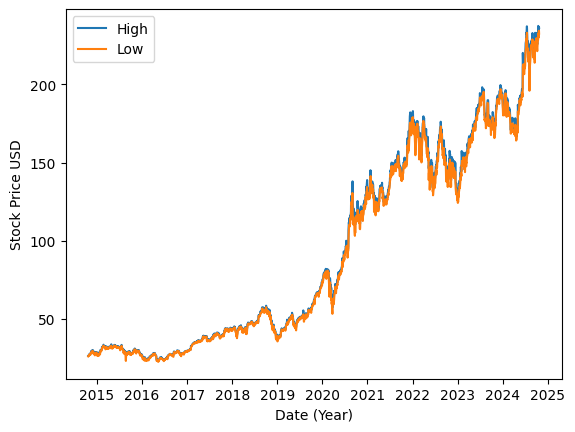

In [27]:
plt.plot(data["Date"], data["High"], label = "High")
plt.plot(data["Date"], data["Low"], label = "Low")
plt.xlabel("Date (Year)")
plt.ylabel("Stock Price USD")
plt.legend()

In [34]:
high = data["High"].to_numpy()

def create_dataset(window_size):
    X = []
    y = []
    for i in range(len(high)-window_size):
        X.append(high[i:i+window_size])
        y.append(high[i+window_size])
    return torch.tensor(X),torch.tensor(y)

X, y = create_dataset(5)
X.shape, y.shape

(torch.Size([2511, 5]), torch.Size([2511]))

In [35]:
for i in range(3):
    print(X[i], y[i])

tensor([26.2628, 26.3725, 26.3700, 26.6850, 26.8425]) tensor(26.8375)
tensor([26.3725, 26.3700, 26.6850, 26.8425, 26.8375]) tensor(27.0100)
tensor([26.3700, 26.6850, 26.8425, 26.8375, 27.0100]) tensor(27.5750)
